In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

print(np.__version__)
print(tf.__version__)
print(cv2.__version__)

1.18.5
2.1.3
4.5.1


###  Defining the Custom Losses

In [7]:
## PSNR and SIMMS loss
import tensorlayer as tl
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303
def compute_psnr(original_image, generated_image):
    original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)
    psnr = tf.image.psnr(original_image, generated_image, max_val = 1.0)
    return tf.math.reduce_mean(psnr, axis = None, keepdims = False, name = None)
def compute_ssim(original_image, generated_image):
    original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)
    ssim = tf.image.ssim(original_image, generated_image, max_val = 1.0, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, )
    return tf.math.reduce_mean(ssim, axis = None, keepdims = False, name = None)
@tf.function
def vgg_19_loss(original_image, generated_image):
    original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)
    original_image_vgg = new_vgg(original_image)
    generated_image_vgg = new_vgg(generated_image)
    vgg_loss = 2e-6*tl.cost.mean_squared_error(generated_image_vgg,original_image_vgg,is_mean=True)
    
    mse_loss = tl.cost.mean_squared_error(generated_image,original_image,is_mean=True)
    return vgg_loss+mse_loss
    #return vgg_loss
def vgg_19_loss_4(original_image, generated_image):
    original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)
    original_image_vgg = new_vgg(original_image)
    generated_image_vgg = new_vgg(generated_image)
    vgg_loss = 3e-5*tl.cost.mean_squared_error(generated_image_vgg,original_image_vgg,is_mean=True)
    
    mse_loss = tl.cost.mean_squared_error(generated_image,original_image,is_mean=True)
    #return vgg_loss+mse_loss
    return vgg_loss+mse_loss

#### Defining the VGG Architecture

In [5]:
## The fully convolutional encoder-decoder network and then creating a new loss function with the VGG_19 loss
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf


vgg_19 = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape=(512,512,3),pooling=None)
vgg_19.summary()

new_vgg = Model(inputs= vgg_19.input,outputs=vgg_19.get_layer('block5_conv4').output)
new_vgg.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
______________________________________________________________

In [8]:
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras as keras
## The fully convolutional encoder-decoder network and then creating a new loss function with the VGG_19 loss
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf



def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l1)
    print('This is the l2\'s shape {}'.format(l2.shape))

    l3 = MaxPooling2D(padding='same')(l2)
    print(l3.shape)
    #l3 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l3)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', bias_initializer='zeros',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l4)
    print('This is L5 shape {}'.format(l5.shape))

    l6 = MaxPooling2D(padding='same')(l5)
    l6 = Dropout(0.3)(l6)
    #l6 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l6)
    print('This is L7 shape {}'.format(l7.shape))
    #l8 = UpSampling2D()(l7)
    l8 = Conv2DTranspose(128,(1,1),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l7)
    # increasing the stide to 2,2 enables upsampling of the images
    print('This is L8 shape {}'.format(l8.shape))
    #l8 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l8)
    l8 = Dropout(0.3)(l8)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',bias_initializer='zeros',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',bias_initializer='zeros',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l9)
    #l10 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l10)
    l10 = Dropout(0.3)(l10)

    l11 = add([l5, l10])
    
    print('This is the l11 shape {}'.format(l11.shape))
    #l12 = UpSampling2D()(l11)
    l12 = Conv2DTranspose(128,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l11)
    
    print('This is the l12\'s shape {}'.format(l12.shape))
    
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',bias_initializer='zeros',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l13)
    
    #l14 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l14)
    l14 = Dropout(0.3)(l14)
    l15 = add([l14, l2])
    l16 = Conv2DTranspose(64,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l15)

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l16)

    print('This is the decoder\'s shape {}'.format(decoded.shape))
    model = Model(input_img, decoded)
    #model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=vgg_19_loss)
    return model

In [34]:
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras as keras
## The fully convolutional encoder-decoder network and then creating a new loss function with the VGG_19 loss
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf




input_img = Input(shape=(256, 256, 3))
l1 = Conv2D(64, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
            activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
            activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l1)
print('This is the l2\'s shape {}'.format(l2.shape))

l3 = MaxPooling2D(padding='same')(l2)
print(l3.shape)
l3 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l3)
#l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', bias_initializer='zeros',
            activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
            activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l4)
print('This is L5 shape {}'.format(l5.shape))

l6 = MaxPooling2D(padding='same')(l5)
l6 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l6)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
            activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l6)
print('This is L7 shape {}'.format(l7.shape))
#l8 = UpSampling2D()(l7)
l8 = Conv2DTranspose(128,(1,1),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                    kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l7)
# increasing the stide to 2,2 enables upsampling of the images
print('This is L8 shape {}'.format(l8.shape))
l8 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l8)
l8 = Dropout(0.3)(l8)
l9 = Conv2D(128, (3, 3), padding='same', activation='relu',bias_initializer='zeros',
            activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',bias_initializer='zeros',
             activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l9)
l10 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l10)
l3 = Dropout(0.3)(l3)

l11 = add([l5, l10])

print('This is the l11 shape {}'.format(l11.shape))
#l12 = UpSampling2D()(l11)
l12 = Conv2DTranspose(128,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                    kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l11)

print('This is the l12\'s shape {}'.format(l12.shape))

l13 = Conv2D(64, (3, 3), padding='same', activation='relu',bias_initializer='zeros',
             activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l13)

l14 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l14)
l15 = add([l14, l2])
l16 = Conv2DTranspose(64,(2,2),padding='same',strides=(2,2),activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                    kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32),data_format='channels_last')(l15)

decoded = Conv2D(3, (3, 3), padding='same', activation='relu', bias_initializer='zeros',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l16)

# print('This is the decoder\'s shape {}'.format(decoded.shape))
# decoder_2 = keras.Model([encoder_inputs],[z_mean,z_log_var,l14,decoder_outputs], name="decoder")
# decoder_2.summary()
model = Model(input_img, decoded)
    #model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


This is the l2's shape (None, 256, 256, 64)
(None, 128, 128, 64)
This is L5 shape (None, 128, 128, 128)
This is L7 shape (None, 64, 64, 256)
This is L8 shape (None, 128, 128, 128)
This is the l11 shape (None, 128, 128, 128)
This is the l12's shape (None, 256, 256, 128)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_40[0][0]                  
____________________

In [36]:
model_2 = VGG(model)
model_2.compile(optimizer=keras.optimizers.Adam(1e-4),loss=None)

In [9]:
model_76 = build_model()
model_76.summary()

This is the l2's shape (None, 256, 256, 64)
(None, 128, 128, 64)
This is L5 shape (None, 128, 128, 128)
This is L7 shape (None, 64, 64, 256)
This is L8 shape (None, 128, 128, 128)
This is the l11 shape (None, 128, 128, 128)
This is the l12's shape (None, 256, 256, 128)
This is the decoder's shape (None, 512, 512, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d

### Training the model with regular mse loss and trainign the model with mse and vgg loss

#### Training with MSE loss and showing training and loss graph functions

###### Data preprocessing and Data loading

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

print(np.__version__)
print(tf.__version__)
print(cv2.__version__)

def load_data(path,size):
    high_res_images = []
    low_res_images = []
    count = 0
    for (dirname, _, filenames_high_res),(dirname, _, filenames_low_res) in zip(os.walk(path+'HIGH'),os.walk(path+'LOW')):
        filenames_high_res.sort()
        filenames_low_res.sort()
        
        for filename_high,filename_low in zip(filenames_high_res,filenames_low_res):
            #faulty image
            
            try:
                count+=1
                img = cv2.imread(os.path.join(dirname, filename_high))
                img_2 = cv2.imread(os.path.join(dirname, filename_low))
                # resizing the images
                width=int(img.shape[1])
                height=int(img.shape[0])
                
                width_2= int(img_2.shape[1])
                height_2=int(img_2.shape[0]) 
            
                if width!= 512 and height !=512:
                    dsize=(512,512)
                    img=cv2.resize(img,dsize)
                  
                if width_2!= 256 and height_2 !=256:
                    dsize=(256,256)
                    img_2=cv2.resize(img_2,dsize)
                
                img = process_image(img)
                img_2 = process_image(img_2)
                high_res_images.append(img)
                low_res_images.append(img_2)
            except:
                continue
            if count >size:
                break
    
    # zero-mean and zero-center the standard deviations ....
    low_res_array = np.array(low_res_images)
    #mean_centered_low_res = (low_res_array - low_res_array.mean())/low_res_array.std()
    
    # zero-mean and zero-center the standard deviations .....
    high_res_array = np.array(high_res_images)
    #mean_centered_high_res = (high_res_array - high_res_array.mean())/high_res_array.std()
    
    
    #return mean_centered_low_res, mean_centered_high_res
    return low_res_array,high_res_array

def process_image(image):
    return image/255

1.18.5
2.1.3
4.5.1


In [13]:
base_dir = ''
train_x, train_y =  load_data(path=base_dir+'Training/',size=7000)
val_x, val_y = load_data(path=base_dir+'Validationing/',size=7000)

In [14]:
train_x.shape

(7000, 256, 256, 3)

In [15]:
train_y.shape

(7000, 512, 512, 3)

In [16]:
val_x.shape

(255, 256, 256, 3)

In [17]:
val_y.shape

(255, 512, 512, 3)

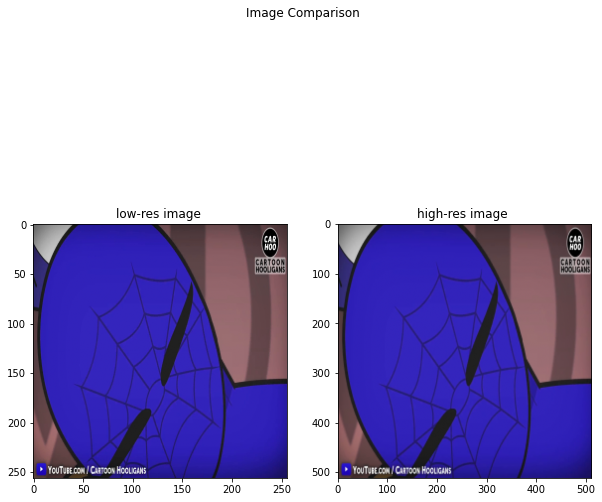

In [18]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
fig.suptitle('Image Comparison')
ax1.imshow(train_x[30])
ax1.title.set_text("low-res image ")
ax2.imshow(train_y[30])
ax2.title.set_text("high-res image ")

In [37]:
### Modifying the train_step
class VGG(keras.Model):
    def __init__(self, decoder,vgg_loss, **kwargs):
        super(VGG, self).__init__(**kwargs)
        self.decoder = decoder
        self.vgg_loss = vgg_loss
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.vgg_loss_tracker = keras.metrics.Mean(name="vgg_loss")
        
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(name="val_reconstruction_loss")
        self.val_vgg_loss_tracker = keras.metrics.Mean(name="val_vgg_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vgg_loss_tracker,
        ]
    
    def call(self, data, training = False):

        if training:
            reconstruction = self.decoder(data) # data is a tuple of encoder_inputs,dim_encoding_2,latent_ratio
        else:
            reconstruction= self.decoder(data)
            return (reconstruction)
        return reconstruction
    
    @tf.function
    def vgg_19_loss_4(original_image, generated_image):
        original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
        generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)
        original_image_vgg = new_vgg(original_image)
        generated_image_vgg = new_vgg(generated_image)
        vgg_loss = 3e-5*tl.cost.mean_squared_error(generated_image_vgg,original_image_vgg,is_mean=True)
    
        return vgg_loss
    
    def train_step(self, data):
        
        with tf.GradientTape() as tape:

            reconstruction = self.decoder(data) # data is a tuple of encoder_inputs,dim_encoding_2,latent_ratio
            
            reconstruction_loss = tf.keras.losses.MSE(data,reconstruction)
            vgg_loss = vgg_19_loss_4(data,reconstruction)
            #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + vgg_loss
        grads = tape.gradient(total_loss, self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.decoder.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vgg_loss": self.vgg_loss_tracker.result(),
        }
    
    def test_step(self,data):
        x = data
        y_pred = self(x,training=False)
        #print(y_pred)
        #z_mean,z_log_var,_,reconstruction = self.decoder(data)
        reconstruction_loss = tf.keras.losses.MSE(data,y_pred)
            
        vgg_loss = vgg_19_loss_4(data,y_pred)
        total_loss = reconstruction_loss + vgg_loss
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_vgg_loss_tracker.update_state(vgg_loss)
        
        return {"total_loss": self.val_total_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "vgg_loss": self.val_vgg_loss_tracker.result(),
            }

In [ ]:
history_76= model_76.fit(train_x, train_y, validation_data =(val_x , val_y),epochs = 30, batch_size = 10, shuffle = True)

Train on 7000 samples, validate on 255 samples
Epoch 1/30
7000/7000 [==============================] - 2306s 329ms/sample - loss: 0.0245 - val_loss: 0.0041
Epoch 2/30
7000/7000 [==============================] - 2218s 317ms/sample - loss: 0.0167 - val_loss: 0.0030
Epoch 3/30
7000/7000 [==============================] - 2230s 319ms/sample - loss: 0.0162 - val_loss: 0.0033
Epoch 4/30
7000/7000 [==============================] - 2240s 320ms/sample - loss: 0.0159 - val_loss: 0.0028
Epoch 5/30
7000/7000 [==============================] - 2246s 321ms/sample - loss: 0.0157 - val_loss: 0.0025
Epoch 6/30
7000/7000 [==============================] - 2243s 320ms/sample - loss: 0.0156 - val_loss: 0.0027
Epoch 7/30
7000/7000 [==============================] - 2249s 321ms/sample - loss: 0.0155 - val_loss: 0.0027
Epoch 8/30
7000/7000 [==============================] - 2256s 322ms/sample - loss: 0.0153 - val_loss: 0.0025
Epoch 9/30
4030/7000 [================>.............] - ETA: 15:39 - loss: 0.0159

In [26]:
model_76.save('CNN_final_VGG_only_1')

INFO:tensorflow:Assets written to: CNN_final_VGG_only_1/assets


KeyError: "Failed to add concrete function b'__inference_vgg_19_loss_52702' to object based saved model as it captures tensor tf.Tensor(<unprintable>, shape=(), dtype=resource) which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history_2.history['loss'])
#plt.plot(history_2.history['kl_loss'])
plt.plot(history_2.history['val_loss'])
#plt.plot(history_2.history['val_kl_loss'])
plt.title('Convolutional Encoder-Decoder VGG Loss Curves')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

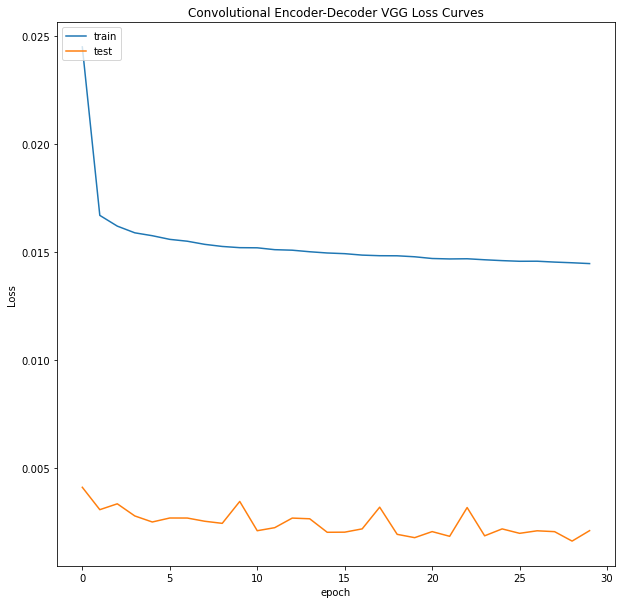

In [22]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history_76.history['loss'])
#plt.plot(history_2.history['kl_loss'])
plt.plot(history_76.history['val_loss'])
#plt.plot(history_2.history['val_kl_loss'])
plt.title('Convolutional Encoder-Decoder VGG Loss Curves')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
reuploaded_model = tf.keras.models.load_model('CNN_final_VGG_only_1')

OSError: SavedModel file does not exist at: CNN_final_VGG_only_1/{saved_model.pbtxt|saved_model.pb}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


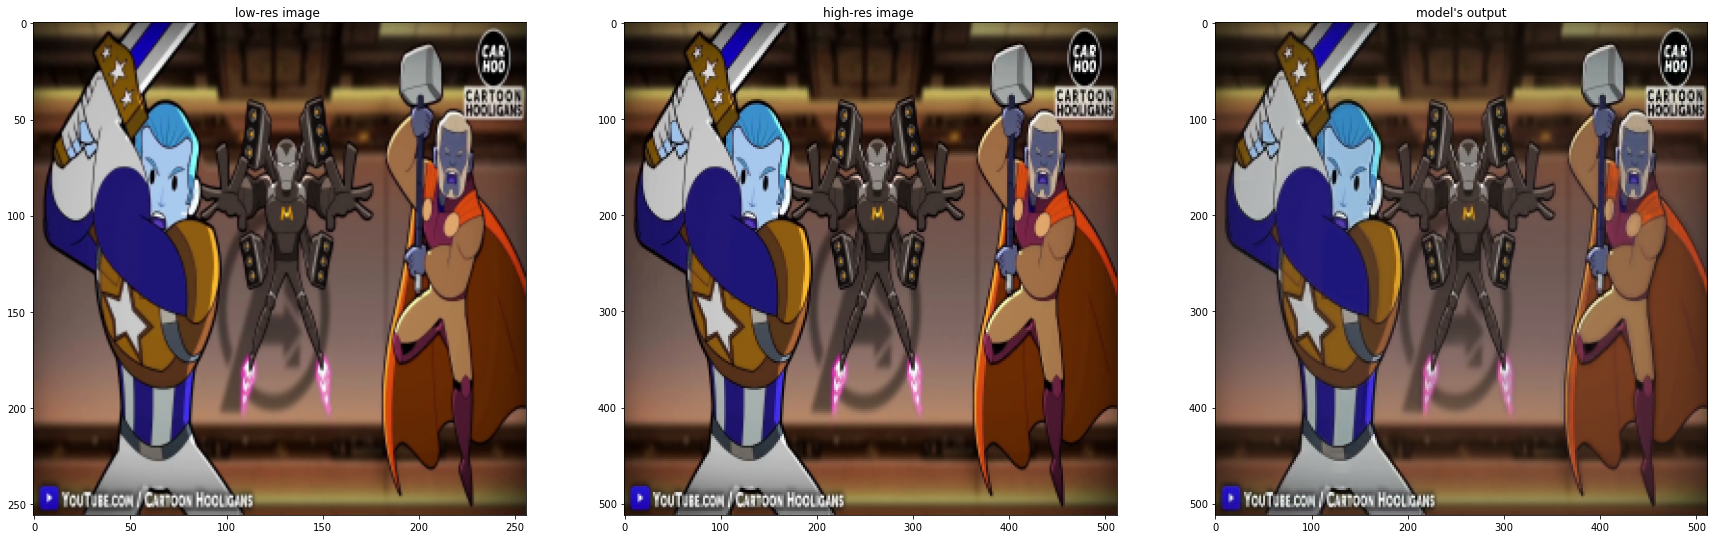

<Figure size 2880x2880 with 0 Axes>

In [25]:
predict_y = model_76.predict(val_x)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[100])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[100])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[100])
ax3.title.set_text("model's output")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


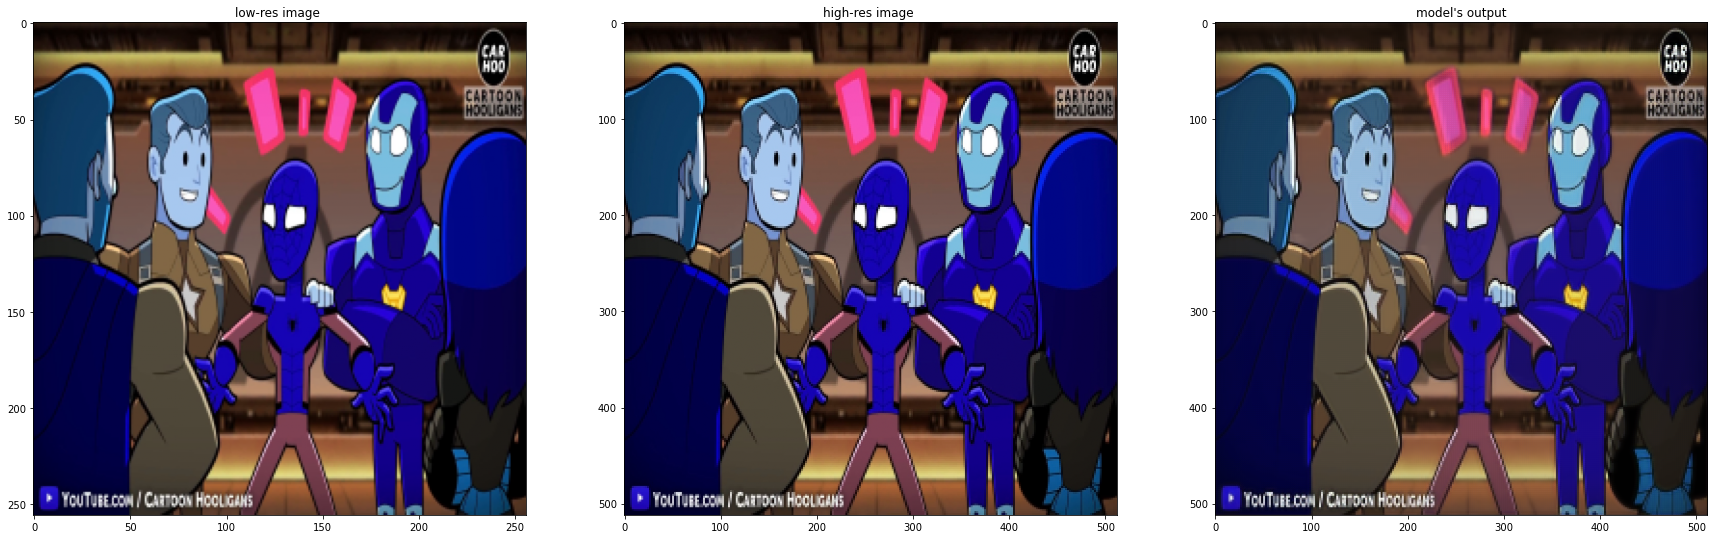

<Figure size 2880x2880 with 0 Axes>

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[25])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[25])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[25])
ax3.title.set_text("model's output")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


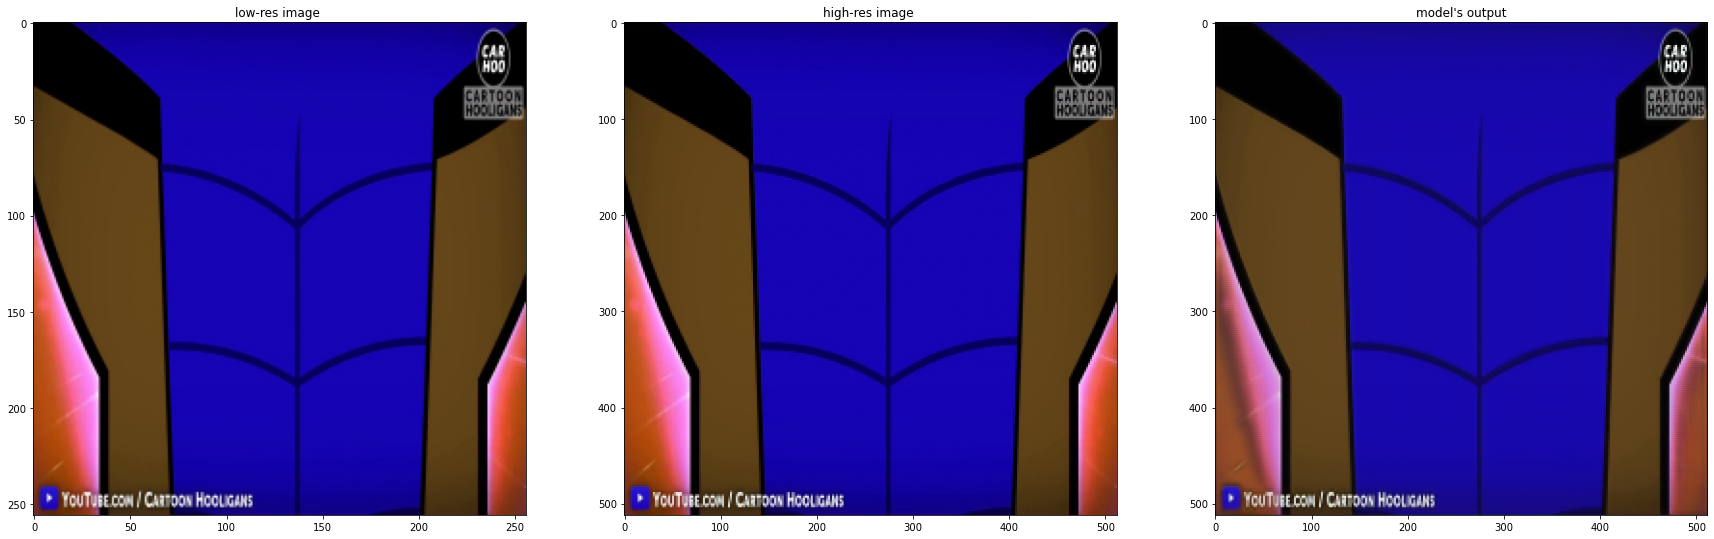

<Figure size 2880x2880 with 0 Axes>

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[200])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[200])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[200])
ax3.title.set_text("model's output")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


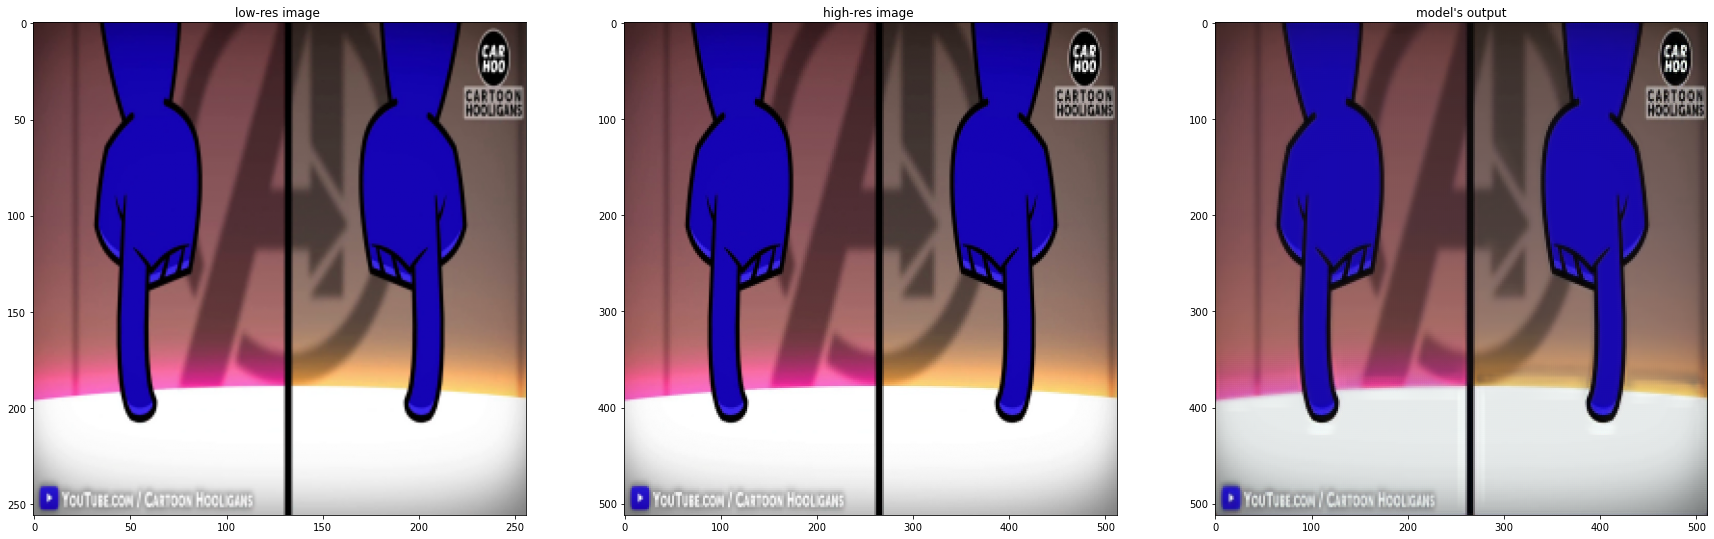

<Figure size 2880x2880 with 0 Axes>

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[250])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[250])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[250])
ax3.title.set_text("model's output")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


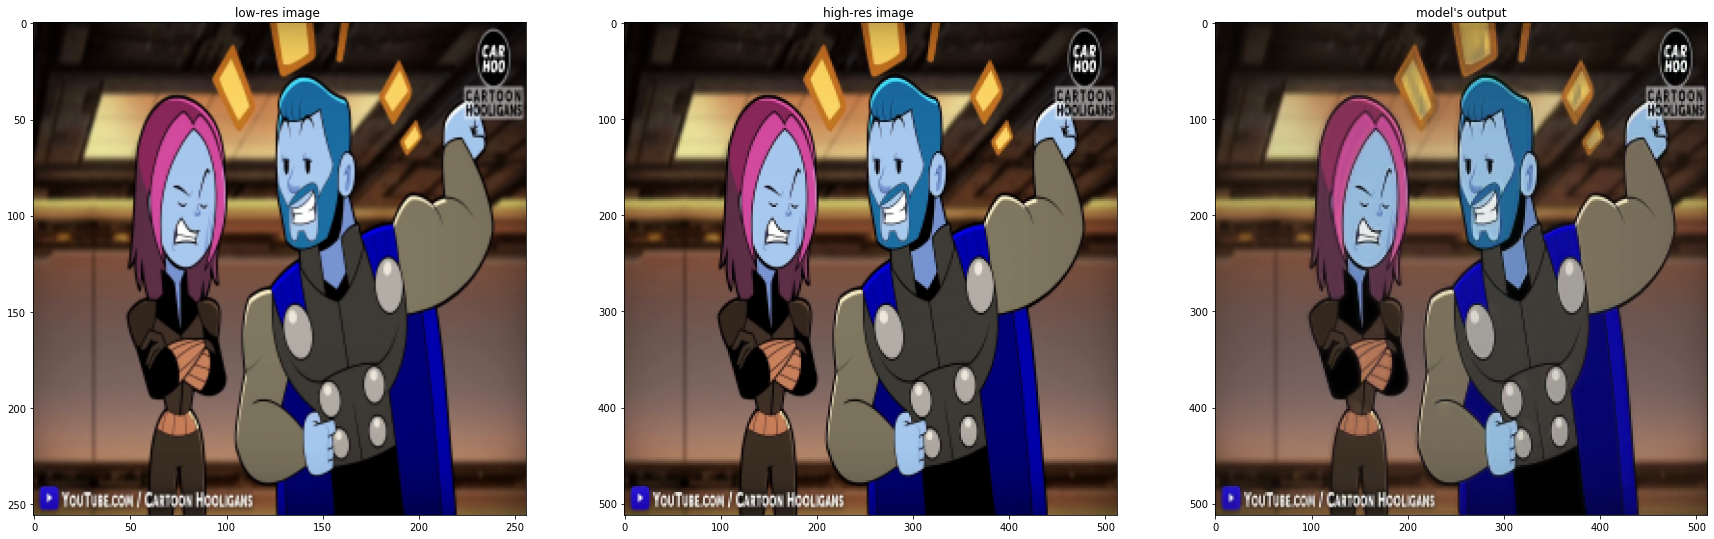

<Figure size 2880x2880 with 0 Axes>

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[140])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[140])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[140])
ax3.title.set_text("model's output")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


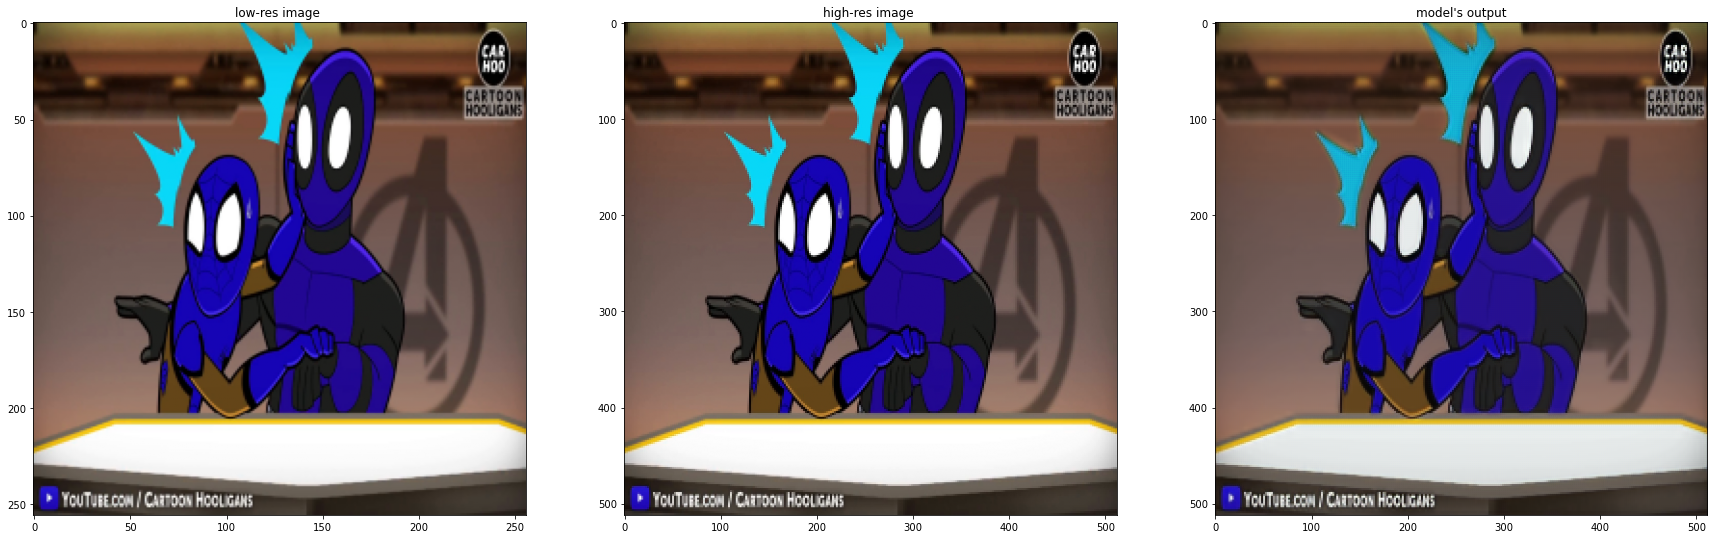

<Figure size 2880x2880 with 0 Axes>

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[97])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[97])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[97])
ax3.title.set_text("model's output")

In [38]:
tf.keras.models.save_model(model_76,'CNN_final_VGG_yes',include_optimizer=True)

INFO:tensorflow:Assets written to: CNN_final_VGG_yes/assets


KeyError: "Failed to add concrete function b'__inference_vgg_19_loss_52702' to object based saved model as it captures tensor tf.Tensor(<unprintable>, shape=(), dtype=resource) which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."